In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt

In [3]:
import pickle
import numpy as np

def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict

In [4]:
def load_cifar10_data(data_dir):
    train_data = []
    train_labels = []

    # Load training batches
    for i in range(1, 6):
        batch = unpickle(f"{data_dir}/data_batch_{i}")
        train_data.append(batch[b'data'])
        train_labels += batch[b'labels']

    train_data = np.concatenate(train_data, axis=0)
    train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to (N, H, W, C)
    train_labels = np.array(train_labels)

    # Load test batch
    test_batch = unpickle(f"{data_dir}/test_batch")
    test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_labels = np.array(test_batch[b'labels'])

    return (train_data, train_labels), (test_data, test_labels)


In [5]:


class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load data
(data_dir) = '/kaggle/input/cifar10-python/cifar-10-batches-py'
(train_data, train_labels), (test_data, test_labels) = load_cifar10_data(data_dir)


In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create PyTorch datasets and loaders
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=transform)
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(4608,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )

    def forward(self,x):
        x = self.conv_layer(x)
        return x

In [9]:
np.sqrt(4608)

67.88225099390856

In [10]:
model = CNN().to(device)

In [11]:
import torch.optim as optim

In [12]:
optimizer = optim.SGD(model.parameters(),lr=1e-04)
loss_fn = nn.CrossEntropyLoss()
epochs = 10

In [13]:
train_losses,test_losses = [],[]
for epoch in range(epochs):
    model.train()
    train_loss =0
    for batch,(x,y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #Metrics 
        train_loss += loss.item()
        
    avg_loss = train_loss/len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch: {epoch} | Train loss: {avg_loss}')

    model.eval()
    with torch.no_grad():
        test_loss,correct=0,0
        for batch,(x,y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = loss_fn(pred,y)

            test_loss += loss.item()
            correct += ((torch.argmax(torch.softmax(pred,dim=1),dim=1)==y).sum().item())
        avg_test_loss = test_loss/len(test_loader)
        avg_correct = correct/len(test_loader)
        test_losses.append(avg_test_loss)
        print(f'Test_loss {avg_test_loss} | Accuracy {avg_correct}')

Epoch: 0 | Train loss: 2.302473039150238
Test_loss 2.302074661254883 | Accuracy 9.99
Epoch: 1 | Train loss: 2.3019743223190305
Test_loss 2.301564588546753 | Accuracy 10.22
Epoch: 2 | Train loss: 2.301473689079285
Test_loss 2.3010514879226687 | Accuracy 10.49
Epoch: 3 | Train loss: 2.300969730377197
Test_loss 2.300533595085144 | Accuracy 10.55
Epoch: 4 | Train loss: 2.300460841655731
Test_loss 2.300009741783142 | Accuracy 10.78
Epoch: 5 | Train loss: 2.299945704460144
Test_loss 2.2994789814949037 | Accuracy 10.96
Epoch: 6 | Train loss: 2.299423637866974
Test_loss 2.298940055370331 | Accuracy 11.2
Epoch: 7 | Train loss: 2.2988923697471617
Test_loss 2.298391332626343 | Accuracy 11.51
Epoch: 8 | Train loss: 2.2983505935668944
Test_loss 2.297832119464874 | Accuracy 11.88
Epoch: 9 | Train loss: 2.2977970910072325
Test_loss 2.2972595477104187 | Accuracy 12.38


In [14]:
(torch.argmax(torch.softmax(pred,dim=1),dim=1)==y).sum()

tensor(13, device='cuda:0')

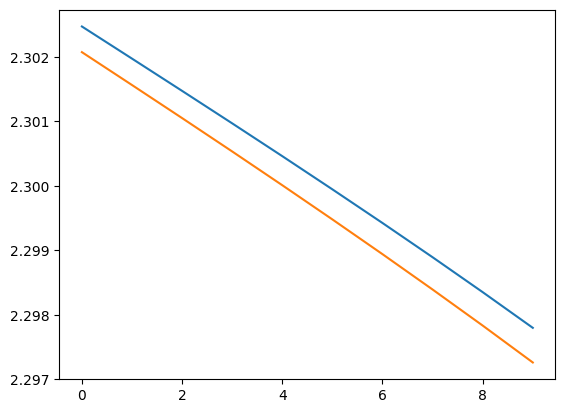

In [15]:
plt.plot(train_losses)
plt.plot(test_losses)